In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/STAGE
%pip install -qr requirements.txt

/content/drive/MyDrive/Colab_Notebooks/STAGE
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/STAGE
import utils
display = utils.notebook_init()

YOLOv5 🚀 2023-5-2 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
import shutil
import torch
from IPython.display import Image, clear_output # to display images
#from utils.google_utils import gdrive_download # to download models/datasets

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
import os
import shutil
import pathlib
import random
import sys
from time import sleep
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import cv2
from skimage import data
from skimage.color import rgb2hsv
import pandas as pd
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/')

In [ ]:
def HSV(image):
    imagecolor = np.asarray(image)
    imagehsv = rgb2hsv(imagecolor)
    H = imagehsv[:,:,0]*255
    S = imagehsv[:,:,1]*255
    V = imagehsv[:,:,2]*255
    return([H,S,V])

def green_index_pixel(image_array,image,i,j):
    red = image_array[0]
    green = image_array[1]
    blue = image_array[2]
    r = red/(red+green+blue)
    g = green/(red+green+blue)
    b = blue/(red+green+blue)
    ExG = 2*g - r -b
    M_ExG = (-0.884 * r) + (1.262 * g) + (0.311 * b)
    ExR = (1.4 * r) - g
    CIVE = (0.441 * r) - (0.811 + g) + (0.385 * b) + 18.787
    VEG = g/((r**0.667)*(b**0.333))
    HSV_parameters = HSV(image)
    if (HSV_parameters[0][i,j] < 50) or (HSV_parameters[0][i,j]>150) or (HSV_parameters[2][i,j] > 49):
        HSVDT = 0
    else:
        HSVDT = 1
    return([ExG,M_ExG, ExR, CIVE, VEG, HSVDT])


def find_max_index(image_array,image):
    max_ExG = 0
    max_M_ExG = 0
    max_ExR = 0
    max_CIVE = 0
    max_VEG = 0
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            pixel = image_array[i,j]
            liste_index = green_index_pixel(pixel,image,i,j)
            if liste_index[0] > max_ExG:
                max_ExG = liste_index[0]
            if liste_index[1] > max_M_ExG:
                max_M_ExG = liste_index[1]
            if liste_index[2] > max_ExR:
                max_ExR = liste_index[2]
            if liste_index[3] > max_CIVE:
                max_CIVE = liste_index[3]
            if liste_index[4] > max_VEG:
                max_VEG = liste_index[4]
    return([max_ExG, max_M_ExG, max_ExR, max_CIVE, max_VEG])


def RGB(pixel):
    red = int(pixel[0])
    green = int(pixel[1])
    blue = int(pixel[2])
    all_rgb = int(red+green+blue)
    if all_rgb == 0:
        (r,g,b) = (0,0,0)
    else:
        r = red/all_rgb
        g = green/all_rgb
        b = blue/all_rgb
    return([r,g,b])

def calcul_ExG(liste_rgb):
    r = liste_rgb[0]
    g = liste_rgb[1]
    b = liste_rgb[2]
    valeurExG = (2*g - r - b)
    return(valeurExG)

def calculMExG(liste_rgb):
    r = liste_rgb[0]
    g = liste_rgb[1]
    b = liste_rgb[2]
    valeurMExG = (-0.884*r) + (1.262*g) - (0.311*b)
    return(valeurMExG)



def ExG(array):
    ExG_array = np.zeros(shape = (array.shape[0],array.shape[1]))
    binary_ExG = np.zeros(shape = (array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            ExG_array[i,j] = calcul_ExG(RGB(array[i,j]))
    max_ExG = np.max(ExG_array)
    for i in range(ExG_array.shape[0]):
        for j in range(ExG_array.shape[1]):
            if ExG_array[i,j] >= max_ExG/10:
                binary_ExG[i,j] = 1
    return(binary_ExG)

def M_ExG(array):
    MExG_array = np.zeros(shape = (array.shape[0],array.shape[1]))
    binary_MExG = np.zeros(shape = (array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            MExG_array[i,j] = calculMExG(RGB(array[i,j]))
    max_MExG = np.max(MExG_array)
    for i in range(MExG_array.shape[0]):
        for j in range(MExG_array.shape[1]):
            if MExG_array[i,j] >= max_MExG/10:
                binary_MExG[i,j] = 1
    return(binary_MExG)


def calcul_ExR(liste_rgb):
    r = liste_rgb[0]
    g = liste_rgb[1]
    valeurExR = 1.4*r - g
    return(valeurExR)

def ExR(array):
    ExR_array = np.zeros(shape = (array.shape[0],array.shape[1]))
    binary_ExR = np.zeros(shape = (array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            ExR_array[i,j] = calcul_ExR(RGB(array[i,j]))
    max_ExR = np.max(ExR_array)
    for i in range(ExR_array.shape[0]):
        for j in range(ExR_array.shape[1]):
            if ExR_array[i,j] >= max_ExR/10:
                binary_ExR[i,j] = 1
    binary_ExR = np.ones(shape = (array.shape[0],array.shape[1])) - binary_ExR
    return(binary_ExR)



def calcul_VEG(liste_rgb):
    r = liste_rgb[0]
    g = liste_rgb[1]
    b = liste_rgb[2]
    if (r**0.667)*(b**0.333) ==0:
        valeurVEG = g
    else:
        valeurVEG = g/((r**0.667)*(b**0.333))
    return(valeurVEG)

def VEG(array):
    VEG_array = np.zeros(shape = (array.shape[0],array.shape[1]))
    binary_VEG = np.zeros(shape = (array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            VEG_array[i,j] = calcul_VEG(RGB(array[i,j]))
    max_VEG = np.max(VEG_array)
    for i in range(VEG_array.shape[0]):
        for j in range(VEG_array.shape[1]):
            if VEG_array[i,j] >= max_VEG/10:
                binary_VEG[i,j] = 1
    return(binary_VEG)



def calcul_CIVE(liste_rgb):
    r = liste_rgb[0]
    g = liste_rgb[1]
    b = liste_rgb[2]
    valeurCIVE = (0.441 * r) - (0.811 + g) + (0.385 * b) + 18.787
    return(valeurCIVE)

def normalize(value,mean,std):
    norm_value = (value-mean)/std
    return(norm_value)

def CIVE(array):
    CIVE_array = np.zeros(shape = (array.shape[0],array.shape[1]))
    binary_CIVE = np.zeros(shape = (array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            CIVE_array[i,j] = calcul_CIVE(RGB(array[i,j]))
    mean_CIVE = np.mean(CIVE_array)
    std_CIVE = np.std(CIVE_array)
    for i in range(CIVE_array.shape[0]):
        for j in range(CIVE_array.shape[1]):
            CIVE_array[i,j] = normalize(CIVE_array[i,j], mean_CIVE, std_CIVE)
            if CIVE_array[i,j] < 0:
                binary_CIVE[i,j] = 1
    return(binary_CIVE)


def calcul_HSV(image):
    imagecolor = np.asarray(image)
    imagehsv = rgb2hsv(imagecolor)
    H = imagehsv[:,:,0]*255
    S = imagehsv[:,:,1]*255
    V = imagehsv[:,:,2]*255
    return([H,S,V])

def HSVDT(image,array):
    binary_HSV = np.zeros(shape = (array.shape[0],array.shape[1]))
    HSV_parameters = calcul_HSV(image)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if (HSV_parameters[0][i,j] < 50) or (HSV_parameters[0][i,j]>150):
                binary_HSV[i,j] = 0
            else:
                binary_HSV[i,j] = 1
    return(binary_HSV)

def metaindex(array,image):
    ExG_ = ExG(array)
    M_ExG_ = M_ExG(array)
    ExR_ = ExR(array)
    VEG_ = VEG(array)
    CIVE_ = CIVE(array)
    HSVDT_ = HSVDT(image,array)
    MI = ExG_ + M_ExG_ + ExR_ + VEG_ + CIVE_ + HSVDT_
    binary_MI = np.zeros(shape = (MI.shape[0],MI.shape[1]))
    for i in range(binary_MI.shape[0]):
        for j in range(binary_MI.shape[1]):
            if MI[i,j] > 3:
                binary_MI[i,j] = 1
    array[:,:,0] = array[:,:,0]*binary_MI
    array[:,:,1] = array[:,:,1]*binary_MI
    array[:,:,2] = array[:,:,2]*binary_MI
    return(array,binary_MI)


In [ ]:
path_test_images = '/content/drive/MyDrive/Colab_Notebooks/STAGE/test/images/'
path_test_labels = '/content/drive/MyDrive/Colab_Notebooks/STAGE/test/labels/'
path_train_images = '/content/drive/MyDrive/Colab_Notebooks/STAGE/train/images/'
path_train_labels = '/content/drive/MyDrive/Colab_Notebooks/STAGE/train/labels/'
path_valid_images = '/content/drive/MyDrive/Colab_Notebooks/STAGE/valid/images/'
path_valid_labels = '/content/drive/MyDrive/Colab_Notebooks/STAGE/valid/labels/'
path_blaresized = '/content/drive/MyDrive/Colab_Notebooks/STAGE/blablablou_resized/'

In [ ]:
shutil.rmtree(path_test_images)
shutil.rmtree(path_test_labels)
shutil.rmtree(path_train_images)
shutil.rmtree(path_train_labels)
shutil.rmtree(path_valid_images)
shutil.rmtree(path_valid_labels)
shutil.rmtree(path_blaresized)

os.mkdir(path_test_images)
os.mkdir(path_test_labels)
os.mkdir(path_train_images)
os.mkdir(path_train_labels)
os.mkdir(path_valid_images)
os.mkdir(path_valid_labels)
os.mkdir(path_blaresized)

In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/images')
file_list = os.listdir()
liste = sorted(file_list)
length = int(len(liste))

In [ ]:
#partie feverole + triticale
import pandas as pd

repartition_tout = []
img_size = 512
count_feverole = 0
count_triticale = 0
for j in tqdm(range(length)):
    try:
        Image.open(liste[j])
        img = Image.open(liste[j])
        img_resized = img.resize((img_size,img_size))
        nam = path_blaresized + str(j) + '.jpg'
        img_resized.save(nam, 'JPEG')
        repartition_tout.append(img_resized)
    except IOError:
        df = pd.read_csv(open(liste[j],"r"), sep = ' ',header = None)
        repartition_tout.append(liste[j])
        continue

100%|██████████| 1880/1880 [07:31<00:00,  4.17it/s]


In [ ]:
count_df= df[0].value_counts()
        try:
            count_df[0]
        except KeyError:
            fev_exists = False
        else:
            fev_exists = True
        try:
            count_df[1]
        except KeyError:
            trit_exists = False
        else:
            trit_exists = True
        if fev_exists == True:
            count_feverole += count_df[0]
        if trit_exists == True:
            count_triticale += count_df[1]

In [ ]:
#partie feverole + triticale
length_repartition = int(len(repartition_tout)/2)
for i in tqdm(range(length_repartition)):
    rd = random.random()
    if rd < 0.7:
        img = repartition_tout[2*i]
        name_image = path_train_images + str(2*i) + '.jpg'
        img.save(name_image, "JPEG")
        name_label = path_train_labels + str(2*i) + '.txt'
        shutil.copy(repartition_tout[(2*i)+1], name_label)
    elif rd >= 0.7 and rd < 0.9:
        img = repartition_tout[2*i]
        name_image = path_test_images + str(2*i) + '.jpg'
        img.save(name_image, "JPEG")
        name_label = path_test_labels + str(2*i) + '.txt'
        shutil.copy(repartition_tout[(2*i)+1], name_label)
    elif rd >= 0.9:
        img = repartition_tout[2*i]
        name_image = path_valid_images + str(2*i) + '.jpg'
        img.save(name_image, "JPEG")
        name_label = path_valid_labels + str(2*i) + '.txt'
        shutil.copy(repartition_tout[(2*i)+1], name_label)
    sleep(0.01)

100%|██████████| 940/940 [00:31<00:00, 29.46it/s]


In [ ]:
#partie feverole ONLY
path = '/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/COCO_images/'

repartition_tout = []
img_size = 512
for j in tqdm(range(length)):
    try:
        Image.open(liste[j])
        img = Image.open(liste[j])
        img_resized = img.resize((img_size,img_size))
        img_array = np.array(img_resized)
        #filter_array = metaindex(img_array,img_resized)
        img_resized = Image.fromarray(img_array)
        nam = path + str(j) + '.jpg'
        img_resized.save(nam, 'JPEG')
        repartition_tout.append(img_resized)
    except IOError:
        df = pd.read_csv(open(liste[j],"r"), sep = ' ',header = None)
        df2 = df.loc[df[0] == 0]
        name_label = path_blaresized + str(j-1) + '.txt'
        with open(name_label, 'a') as f:
            df_string = df2.to_string(header=False, index=False)
            f.write(df_string)
        repartition_tout.append(df_string)
        continue

NameError: ignored

In [ ]:
#partie feverole ONLY
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/blablablou_resized/')
path = '/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/COCO_mask/COCO_images/'
file_list_fev = os.listdir()
length_fev = int(len(file_list_fev)/2)
for i in tqdm(range(length_fev)):
    rd = random.random()
    if rd < 0.7:
        img = repartition_tout[2*i]
        name_image = path_train_images + str(2*i) + '.jpg'
        img.save(name_image, "JPEG")
        name_label = path_train_labels + str(2*i) + '.txt'
        shutil.copy(file_list_fev[(2*i)+1], name_label)
    elif rd >= 0.7 and rd < 0.9:
        img = repartition_tout[2*i]
        name_image = path_test_images + str(2*i) + '.jpg'
        img.save(name_image, "JPEG")
        name_label = path_test_labels + str(2*i) + '.txt'
        shutil.copy(file_list_fev[(2*i)+1], name_label)
    elif rd >= 0.9:
        img = repartition_tout[2*i]
        name_image = path_valid_images + str(2*i) + '.jpg'
        img.save(name_image, "JPEG")
        name_label = path_valid_labels + str(2*i) + '.txt'
        shutil.copy(file_list_fev[(2*i)+1], name_label)
    sleep(0.01)

100%|██████████| 940/940 [00:34<00:00, 27.00it/s]


In [ ]:
#COCO_mask

path_triticale = '/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/Semantic/2_triticale/'
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/COCO_images/')
file_list_COCO = os.listdir()
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/Semantic/1_feverole/')
FEVEROLE = os.listdir()
img_size = 512
for i in tqdm(range(len(file_list_COCO))):
    os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/COCO_images/')
    file_list_COCO = os.listdir()
    img = Image.open(file_list_COCO[i])
    img_array = np.array(img)
    bin_array = metaindex(img_array,img)[1]
    os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/Semantic/1_feverole/')
    FEVEROLE = os.listdir()
    img_fev = Image.open(FEVEROLE[i])
    fev_array = np.array(img_fev)
    copy = bin_array
    for i in range(img_size):
        for j in range(img_size):
            if fev_array[i,j] > 0:
                copy[i,j] = 0
    copy = copy*255
    copy_img = Image.fromarray(copy)
    copy_img = copy_img.convert("L")
    nam = path_triticale + str(i) + '.jpg'
    copy_img.save(nam, 'JPEG')

100%|██████████| 940/940 [1:01:58<00:00,  3.96s/it]


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/STAGE/
!python train.py --img 512 --batch 40 --epochs 180 --data /content/drive/MyDrive/Colab_Notebooks/STAGE/data.yaml --cfg yolov5l.yaml --weights '' --patience 0
%cp /content/drive/MyDrive/Colab_Notebooks/STAGE/runs/train/exp/weights/best.pt /content/drive/MyDrive/Colab_Notebooks/STAGE/best.pt

/content/drive/MyDrive/Colab_Notebooks/STAGE
train: weights=, cfg=yolov5l.yaml, data=/content/drive/MyDrive/Colab_Notebooks/STAGE/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=180, batch_size=40, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=0, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
requirements: /content/drive/MyDrive/Colab_Notebooks/requirements.txt not found, check failed.
YOLOv5 🚀 2023-5-2 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.

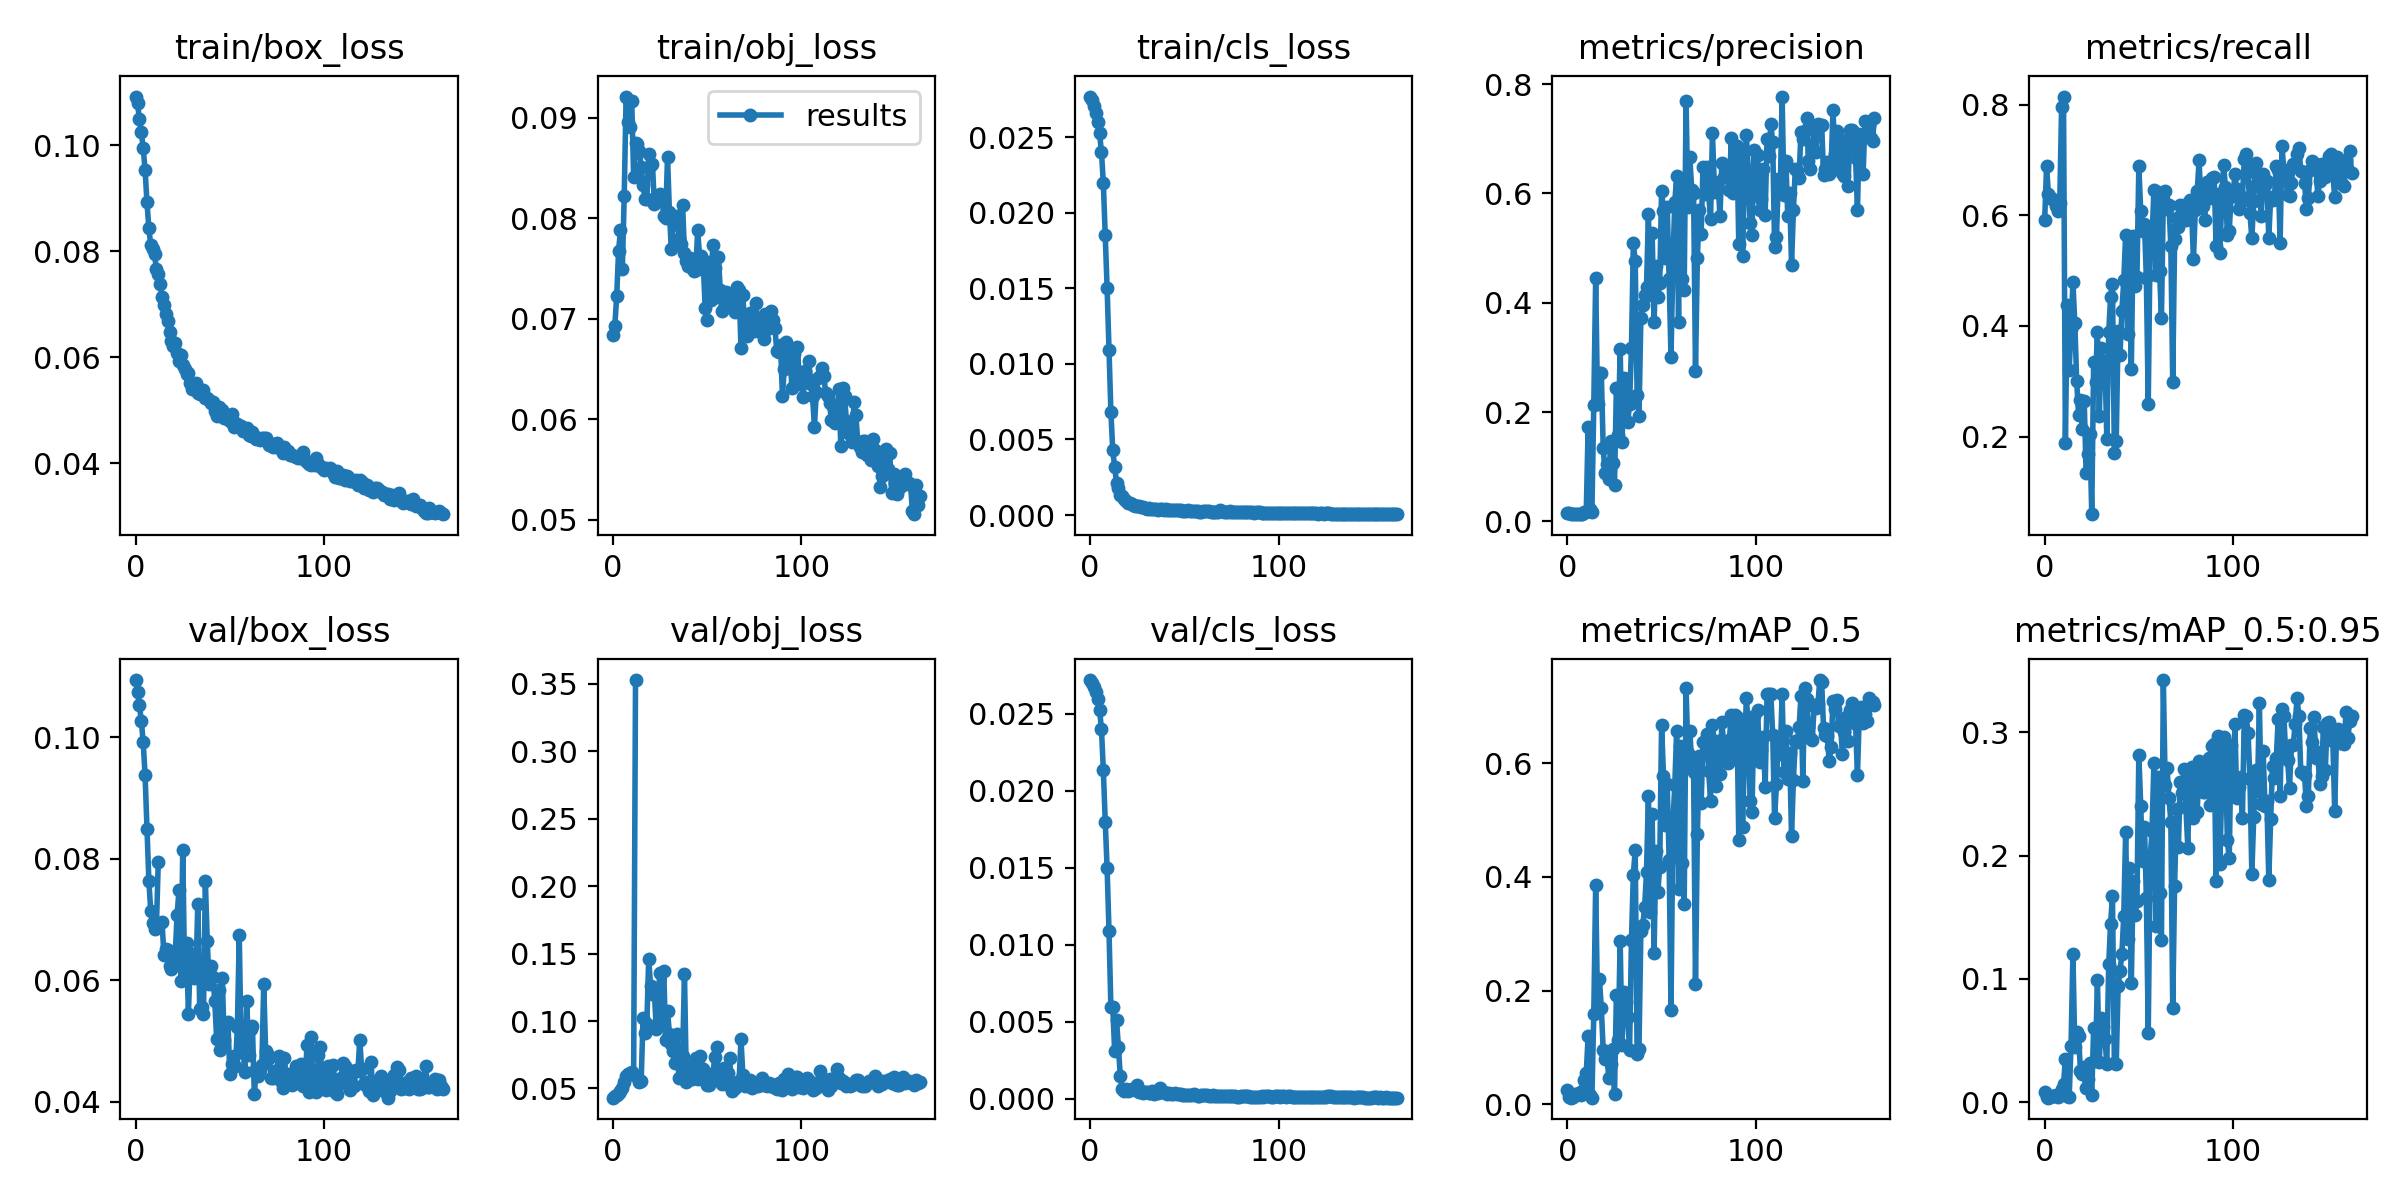

In [ ]:
#changer le numéro de l'exp
from utils.plots import plot_results
plot_results('/content/drive/MyDrive/Colab_Notebooks/STAGE/runs/train/exp10/results.csv')
Image.open('/content/drive/MyDrive/Colab_Notebooks/STAGE/runs/train/exp10/results.png')

In [ ]:
#changer le numéro de l'exp
%cp /content/drive/MyDrive/Colab_Notebooks/STAGE/runs/train/exp10/weights/best.pt /content/drive/MyDrive/Colab_Notebooks/STAGE/

In [ ]:
%cp /content/drive/MyDrive/Colab_Notebooks/STAGE/best.pt /content/drive/MyDrive/Colab_Notebooks/STAGE/runs
%cp -r /content/drive/MyDrive/Colab_Notebooks/STAGE/images_detect/ /content/drive/MyDrive/Colab_Notebooks/STAGE/data/images/

cp: cannot stat '/content/drive/MyDrive/Colab_Notebooks/STAGE/images_detect/': No such file or directory


In [ ]:
path_detect = '/content/drive/MyDrive/Colab_Notebooks/STAGE/data/images/'
list_detect = os.listdir(path_detect)
length_detect = int(len(list_detect))
path_detect_resize = '/content/drive/MyDrive/Colab_Notebooks/STAGE/data/images_resized/'


In [ ]:
os.chdir(path_detect)
shutil.rmtree(path_detect_resize)
os.mkdir(path_detect_resize)
img_size = 512
list_detect = os.listdir()

for l in tqdm(range(length_detect)):
    img = Image.open(list_detect[l])
    img_resized = img.resize((img_size,img_size))
    img_array = np.array(img_resized)
    filter_array = metaindex(img_array,img_resized)
    img_resized = Image.fromarray(filter_array)
    name_image = path_detect_resize + str(l) + '.jpg'
    img_resized.save(name_image, "JPEG")

  0%|          | 0/1 [00:05<?, ?it/s]


AttributeError: ignored

In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE')
!python detect.py --weights '/content/drive/MyDrive/Colab_Notebooks/STAGE/runs/best.pt' --img 512 --conf 0.3 --source '/content/drive/MyDrive/Colab_Notebooks/STAGE/data/images_resized/'  --hide-label

%cp -r /content/drive/MyDrive/Colab_Notebooks/STAGE/runs/detect/exp /content/drive/MyDrive/Colab_Notebooks/STAGE/images_traitees/exp1024_0.2

detect: weights=['/content/drive/MyDrive/Colab_Notebooks/STAGE/runs/best.pt'], source=/content/drive/MyDrive/Colab_Notebooks/STAGE/data/images_resized/, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/drive/MyDrive/Colab_Notebooks/requirements.txt not found, check failed.
YOLOv5 🚀 2023-5-2 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
image 1/2 /content/drive/MyDrive/Colab_Notebooks/STAGE/data/images_resized/0.jpg: 512x512 3 feveroles, 31.8ms
image 2/2 /content/drive/MyDrive/Colab_Notebooks/STAGE/data/images_resized/

In [ ]:
#change runs/detect/exp[number]
mask_path = '/content/drive/MyDrive/Colab_Notebooks/STAGE/mask/'
shutil.rmtree(mask_path)
os.mkdir(mask_path)
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/runs/detect/exp4/')

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

list_mask = os.listdir()
for image in tqdm(range(len(list_mask))):
    img = Image.open(list_mask[image])
    imagecolor = np.asarray(img)
    binary = np.zeros(shape = (imagecolor.shape[0],imagecolor.shape[1]))
    for i in range(len(imagecolor[0])):
        for j in range(len(imagecolor[1])):
            if (imagecolor[i,j][0] > 200) and (imagecolor[i,j][1] < 100) and (imagecolor[i,j][2] < 100):
                binary[i,j] = 1
    kernel = np.ones((5, 5), np.uint8)
    im_out=ndi.convolve(binary,kernel, mode='constant', cval=0.0)
    fill = ndi.binary_fill_holes(im_out).astype(int)
    mask = imagecolor.copy()
    for i in range(fill.shape[0]):
        for j in range(fill.shape[1]):
            if fill[i,j] == 1:
                mask[i,j] = (0,0,0)
    pil_image=Image.fromarray(mask)
    name_image = mask_path + str(image) + '.jpg'
    pil_image.save(name_image, "JPEG")





100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [ ]:
def RGB2HSV(image):
    imagecolor = np.asarray(image)
    imagehsv = rgb2hsv(imagecolor)
    H = imagehsv[:,:,0]
    S = imagehsv[:,:,1]
    V = imagehsv[:,:,2]
    return([H,S,V,imagecolor])

def calcul_DGCI(H_pixel,S_pixel,V_pixel):
    DGCI = (((H_pixel-60)/60) + (1-S_pixel) + (1-V_pixel))/3
    return(DGCI)

def mean_DGCI(image):
    H = RGB2HSV(image)[0]
    S = RGB2HSV(image)[1]
    V = RGB2HSV(image)[2]
    image_array = RGB2HSV(image)[3]
    DGCI_array = np.zeros(shape = ((image_array.shape[0],(image_array.shape[1]))))
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            if (H[i,j] == 0) and (H[i,j] == 0) and (H[i,j] == 0):
                DGCI_array[i,j] = float('NaN')
            else:
                DGCI_array[i,j] = calcul_DGCI(H[i,j],S[i,j],V[i,j])
    return(DGCI_array,np.nanmean(DGCI_array))

def norm_DGCI(image):
    DGCI_norm = mean_DGCI(image)[0]
    max_dgci = np.nanmax(DGCI_norm)
    min_dgci = np.nanmin(DGCI_norm)
    for i in range(DGCI_norm.shape[0]):
        for j in range(DGCI_norm.shape[1]):
            DGCI_norm[i,j] = (DGCI_norm[i,j] - min_dgci)/(max_dgci - min_dgci) #possibilité de plt.imshow en multipliant par 255
    return(DGCI_norm, np.nanmean(DGCI_norm))

In [ ]:
os.chdir(mask_path)
list_images_dgci = os.listdir()
moyenne_dgci = []
from openpyxl import load_workbook

for image in tqdm(range(len(list_mask))):
    img = Image.open(list_mask[image])
    imagecolor = np.array(img)
    moyenne_norm_dgci = norm_DGCI(imagecolor)[1]
    moyenne_dgci.append(moyenne_norm_dgci)


100%|██████████| 547/547 [08:08<00:00,  1.12it/s]


FileNotFoundError: ignored

In [ ]:
wb = load_workbook('/content/drive/MyDrive/Colab_Notebooks/STAGE/test.xlsx')
sheet = wb.worksheets[0]

sheet.cell(row = 1, column = 1).value="image"
sheet.cell(row = 1, column = 2).value="moyenne_dgci"

j=2
for i in range(len(list_images_dgci)):
    sheet.cell(row = j, column = 1).value=list_images_dgci[i]
    sheet.cell(row = j, column = 2).value=moyenne_dgci[i]
    j += 1
wb.save('/content/drive/MyDrive/Colab_Notebooks/STAGE/test.xlsx')

In [ ]:
# SAM

In [ ]:
import os
HOME = '/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/'
print("HOME:", HOME)

HOME: /content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/


In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gfcqopfq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gfcqopfq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=d6a479e31a841c1691873dd11eada6ac24751c463fc71d19bdbd13175a8c0c62
  Stored in directory: /tmp/pip-ephem-wheel-cache-__ft1e9p/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.

In [ ]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd
import torch
image_path = '/content/drive/MyDrive/Colab_Notebooks/STAGE/images/'
mask_path = '/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/Semantic/1_feverole/'
box_path = '/content/drive/MyDrive/Colab_Notebooks/STAGE/box_filtre/'

sam_checkpoint = 'sam_vit_h_4b8939.pth'
device = 'cuda'
model_type = 'default'
weight_path = '/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/weights'
os.chdir(weight_path)
sam = sam_model_registry[model_type](checkpoint = sam_checkpoint)
sam.to(device = device)
mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

In [ ]:
import os

# Spécifiez le chemin du dossier contenant les fichiers texte
dossier_source = '/content/drive/MyDrive/Colab_Notebooks/STAGE/box/'

# Spécifiez le chemin du dossier où vous souhaitez enregistrer les fichiers filtrés
dossier_destination = '/content/drive/MyDrive/Colab_Notebooks/STAGE/box_filtre/'

# Assurez-vous que le dossier de destination existe, sinon, créez-le
if not os.path.exists(dossier_destination):
    os.makedirs(dossier_destination)

# Parcours de tous les fichiers du dossier source
for nom_fichier in os.listdir(dossier_source):
    chemin_fichier_source = os.path.join(dossier_source, nom_fichier)

    # Vérifier si le fichier est un fichier texte
    if nom_fichier.endswith(".txt"):
        with open(chemin_fichier_source, "r") as fichier:
            lignes = fichier.readlines()

        # Créez un nouveau chemin pour enregistrer les fichiers filtrés dans le dossier de destination
        chemin_fichier_destination = os.path.join(dossier_destination, nom_fichier)

        with open(chemin_fichier_destination, "w") as fichier_filtre:
            for ligne in lignes:
                if ligne.startswith("0"):
                    fichier_filtre.write(ligne)


In [ ]:
def est_document_texte_vide(chemin_fichier):
    # Ouvre le fichier en mode lecture
    with open(chemin_fichier, 'r') as fichier:
        # Lit le contenu du fichier
        contenu = fichier.read()
        # Vérifie si le contenu est vide (c'est-à-dire si la taille est égale à zéro)
        if len(contenu) == 0:
            return True
        else:
            return False

def segmentation_sam(image_number):
    os.chdir(image_path)
    list_image = os.listdir()
    image_size = 512
    image = cv2.imread(list_image[image_number])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    os.chdir(box_path)
    box_list = os.listdir(box_path)
    mask_total = np.zeros((image_size,image_size),dtype = bool)
    chemin_du_document = os.path.join(box_path, box_list[image_number])

    if est_document_texte_vide(chemin_du_document):
        pil_image = Image.fromarray((mask_total).astype(np.uint8))
        pil_image = pil_image.convert("L")

    else:
        df = pd.read_csv(open(box_list[image_number],"r"), sep = ' ',header = None)
        for n_box in range(df.shape[0]):
            coord_box = df.loc[n_box]
            x,y,w,h = int(coord_box[1]*512),int(coord_box[2]*512),int(coord_box[3]*512),int(coord_box[4]*512)
            box = np.array([x-int(w/2),
                            y-int(h/2),
                            x+int(w/2),
                            y+int(h/2)])
            masks, scores, logits = predictor.predict(box=box,multimask_output=True)
            mask_total = mask_total + sum(masks)

        for i in range(image_size):
            for j in range(image_size):
                if mask_total[i,j] >= 1:
                    mask_total[i,j] = 1

        pil_image = Image.fromarray((mask_total * 255).astype(np.uint8))
        pil_image = pil_image.convert("L")

    name_image = mask_path + str(1880+(image_number*2)) + '.jpg'
    pil_image.save(name_image,"JPEG")

In [ ]:
os.chdir(image_path)
list_image = os.listdir()
for number_image in range(len(list_image)):
    segmentation_sam(number_image)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks/STAGE/COCO_dataset/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:

!python train.py


Got 44634867/60030976 with acc 74.35
Dice score: 0.0
100% 158/158 [07:16<00:00,  2.76s/it, loss=-74.5]
=> Saving checkpoint
Got 21252630/60030976 with acc 35.40
Dice score: 1.5786195993423462
100% 158/158 [02:06<00:00,  1.25it/s, loss=-375]
=> Saving checkpoint
Got 12646806/60030976 with acc 21.07
Dice score: 1.6013832092285156
100% 158/158 [02:05<00:00,  1.26it/s, loss=-531]
=> Saving checkpoint
Got 12646806/60030976 with acc 21.07
Dice score: 1.6013832092285156
100% 158/158 [02:05<00:00,  1.26it/s, loss=-768]
=> Saving checkpoint
Got 12646806/60030976 with acc 21.07
Dice score: 1.6013832092285156
100% 158/158 [02:04<00:00,  1.27it/s, loss=-1.22e+3]
=> Saving checkpoint
Got 12646806/60030976 with acc 21.07
Dice score: 1.6013832092285156
100% 158/158 [02:04<00:00,  1.27it/s, loss=-2.86e+3]
=> Saving checkpoint
Got 12646806/60030976 with acc 21.07
Dice score: 1.6013832092285156
100% 158/158 [02:04<00:00,  1.27it/s, loss=-2.1e+3]
=> Saving checkpoint
Got 12646806/60030976 with acc 21.07
